ניתוח data להקמת מרכז לבעלי חיים אבודים:
תוכן ענינים:
<ol>
<li>ניתוח זמני השהיה לאור נושאים שונים</li> 
<li>כמות האימוץ ביחס למצב הבריאותי</li>   
<li>חיזויים</li> 
<li>ניתוח פעילות במרכז</li>
</ol>

<h3>הקדמה :
   הנתונים נלקחו מבית אימוץ באוסטין טקסס שבארה"ב הנתונים הם מהשנים 2013-2020,של 160,000 בעלי חיים.<h3>
<div>
<img src="animalshelter.JPG" width="400"/>
</div>
 <a> href="https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes" >Link to kaggle data</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_error

יבוא הקבצים ואיחודם

In [2]:
file_intakes = 'https://raw.githubusercontent.com/meirPazKershtain/final_project2021/main/Austin_Animal_Center_Intakes.csv'
file_intakes = pd.read_csv(file_intakes)
file_intakes.tail(2)

,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color
124118,A830171,NaN,03/03/2021 05:13:00 PM,03/03/2021 05:13:00 PM,1310 West Howard Lane in Austin (TX),Stray,Normal,Dog,Intact Female,1 year,Plott Hound Mix,Brown Brindle/White
124119,A830181,Nona,03/03/2021 04:31:00 PM,03/03/2021 04:31:00 PM,Austin (TX),Owner Surrender,Normal,Cat,Spayed Female,4 years,Domestic Shorthair Mix,White/Black


In [3]:
file_Outcomes ='https://raw.githubusercontent.com/meirPazKershtain/final_project2021/main/Austin_Animal_Center_Outcomes.csv'
file_Outcomes = pd.read_csv(file_Outcomes)
file_Outcomes.tail(2)

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
124489,A829964,NaN,03/03/2021 05:57:00 PM,03/03/2021 05:57:00 PM,11/27/2020,Adoption,NaN,Dog,Neutered Male,3 months,Labrador Retriever,Cream
124490,A828158,Odin,03/03/2021 05:19:00 PM,03/03/2021 05:19:00 PM,03/09/2020,Adoption,NaN,Dog,Neutered Male,11 months,Rottweiler Mix,Black/Tan


In [4]:
full_file = pd.merge(file_intakes,file_Outcomes,on='Animal ID')
full_file
full_file.tail(2)

,Animal ID,Name_x,DateTime_x,MonthYear_x,Found Location,Intake Type,Intake Condition,Animal Type_x,Sex upon Intake,Age upon Intake,Breed_x,Color_x,Name_y,DateTime_y,MonthYear_y,Date of Birth,Outcome Type,Outcome Subtype,Animal Type_y,Sex upon Outcome,Age upon Outcome,Breed_y,Color_y
160426,A829868,Remy,02/25/2021 11:40:00 AM,02/25/2021 11:40:00 AM,Valdez in Austin (TX),Stray,Normal,Dog,Neutered Male,1 year,Beagle/Labrador Retriever,Tricolor,Remy,03/03/2021 03:47:00 PM,03/03/2021 03:47:00 PM,02/25/2020,Adoption,NaN,Dog,Neutered Male,1 year,Beagle/Labrador Retriever,Tricolor
160427,A828158,Odin,01/08/2021 07:01:00 PM,01/08/2021 07:01:00 PM,2224 E Stassney in Austin (TX),Stray,Normal,Dog,Intact Male,10 months,Rottweiler Mix,Black/Tan,Odin,03/03/2021 05:19:00 PM,03/03/2021 05:19:00 PM,03/09/2020,Adoption,NaN,Dog,Neutered Male,11 months,Rottweiler Mix,Black/Tan


In [5]:
full_file.keys()

Index(['Animal ID', 'Name_x', 'DateTime_x', 'MonthYear_x', 'Found Location',
       'Intake Type', 'Intake Condition', 'Animal Type_x', 'Sex upon Intake',
       'Age upon Intake', 'Breed_x', 'Color_x', 'Name_y', 'DateTime_y',
       'MonthYear_y', 'Date of Birth', 'Outcome Type', 'Outcome Subtype',
       'Animal Type_y', 'Sex upon Outcome', 'Age upon Outcome', 'Breed_y',
       'Color_y'],
      dtype='object')

ניקוי הדאטה מעמודות   שלא רלוונטיות להמשך

In [6]:
full_file = full_file.drop(columns=['Found Location' ,'Name_x','MonthYear_x','MonthYear_y','Outcome Subtype','Name_y','Breed_x','Animal Type_y','Color_x','Age upon Outcome','Age upon Intake','Breed_x', 'Color_x'])

In [7]:
full_file.isnull().sum().sort_values(ascending=False)

Outcome Type        29
Sex upon Outcome     1
Sex upon Intake      1
Color_y              0
Breed_y              0
Date of Birth        0
DateTime_y           0
Animal Type_x        0
Intake Condition     0
Intake Type          0
DateTime_x           0
Animal ID            0
dtype: int64

In [8]:
full_file.dropna(inplace=True)

In [9]:
full_file.isnull().sum().sort_values(ascending=False)

Color_y             0
Breed_y             0
Sex upon Outcome    0
Outcome Type        0
Date of Birth       0
DateTime_y          0
Sex upon Intake     0
Animal Type_x       0
Intake Condition    0
Intake Type         0
DateTime_x          0
Animal ID           0
dtype: int64

   datetime-העברה ל  

In [10]:
full_file['DateTime_x'] = pd.to_datetime(full_file.DateTime_x)#תאריך כניסה
full_file['DateTime_y'] = pd.to_datetime(full_file.DateTime_y)#תאריך יציאה

In [11]:
how_long_duration =full_file[['Date of Birth','DateTime_x','DateTime_y','Animal Type_x','Intake Condition','Outcome Type','Intake Type','Sex upon Outcome','Breed_y','Color_y']]
how_long_duration.tail()

,Date of Birth,DateTime_x,DateTime_y,Animal Type_x,Intake Condition,Outcome Type,Intake Type,Sex upon Outcome,Breed_y,Color_y
160422,03/03/2020,2021-03-03 13:28:00,2021-03-03 14:46:00,Other,Sick,Euthanasia,Wildlife,Unknown,Raccoon,Black
160424,09/21/2017,2021-02-21 14:56:00,2021-02-21 17:28:00,Dog,Normal,Adoption,Stray,Intact Male,Chihuahua Shorthair,Brown
160425,11/14/2017,2018-01-14 11:31:00,2018-01-15 17:12:00,Dog,Normal,Adoption,Owner Surrender,Neutered Male,Chihuahua Shorthair Mix,Tan/White
160426,02/25/2020,2021-02-25 11:40:00,2021-03-03 15:47:00,Dog,Normal,Adoption,Stray,Neutered Male,Beagle/Labrador Retriever,Tricolor
160427,03/09/2020,2021-01-08 19:01:00,2021-03-03 17:19:00,Dog,Normal,Adoption,Stray,Neutered Male,Rottweiler Mix,Black/Tan


מציאת הזמן בין הכניסה ליציאה

In [12]:
how_long_duration = how_long_duration.copy()
how_long_duration['duration'] = how_long_duration['DateTime_y'] - how_long_duration['DateTime_x']
how_long_duration['Date of Birth'] = pd.to_datetime(how_long_duration['Date of Birth'])
how_long_duration['Age upon Intake']=how_long_duration['DateTime_x']-how_long_duration['Date of Birth']  
how_long_duration['Age upon Outcome']=how_long_duration['DateTime_y']-how_long_duration['Date of Birth']
how_long_duration.tail(3)

,Date of Birth,DateTime_x,DateTime_y,Animal Type_x,Intake Condition,Outcome Type,Intake Type,Sex upon Outcome,Breed_y,Color_y,duration,Age upon Intake,Age upon Outcome
160425,2017-11-14,2018-01-14 11:31:00,2018-01-15 17:12:00,Dog,Normal,Adoption,Owner Surrender,Neutered Male,Chihuahua Shorthair Mix,Tan/White,1 days 05:41:00,61 days 11:31:00,62 days 17:12:00
160426,2020-02-25,2021-02-25 11:40:00,2021-03-03 15:47:00,Dog,Normal,Adoption,Stray,Neutered Male,Beagle/Labrador Retriever,Tricolor,6 days 04:07:00,366 days 11:40:00,372 days 15:47:00
160427,2020-03-09,2021-01-08 19:01:00,2021-03-03 17:19:00,Dog,Normal,Adoption,Stray,Neutered Male,Rottweiler Mix,Black/Tan,53 days 22:18:00,305 days 19:01:00,359 days 17:19:00


In [13]:
int_intake=how_long_duration['Age upon Intake']##העברה למספר על פי הימים בתאריכי כניסה יציאה וזמן שההייה
int_intake=int_intake.dt.days
how_long_duration['Age upon Intake']=int_intake

int_outcome=how_long_duration['Age upon Outcome']
int_outcome=int_outcome.dt.days
how_long_duration['Age upon Outcome']=int_outcome

int_duration=how_long_duration['duration']
int_duration=int_duration.dt.days
how_long_duration['duration']=int_duration
how_long_duration.tail(3)

,Date of Birth,DateTime_x,DateTime_y,Animal Type_x,Intake Condition,Outcome Type,Intake Type,Sex upon Outcome,Breed_y,Color_y,duration,Age upon Intake,Age upon Outcome
160425,2017-11-14,2018-01-14 11:31:00,2018-01-15 17:12:00,Dog,Normal,Adoption,Owner Surrender,Neutered Male,Chihuahua Shorthair Mix,Tan/White,1,61,62
160426,2020-02-25,2021-02-25 11:40:00,2021-03-03 15:47:00,Dog,Normal,Adoption,Stray,Neutered Male,Beagle/Labrador Retriever,Tricolor,6,366,372
160427,2020-03-09,2021-01-08 19:01:00,2021-03-03 17:19:00,Dog,Normal,Adoption,Stray,Neutered Male,Rottweiler Mix,Black/Tan,53,305,359


  כמות בעלי החיים לכל סוג 

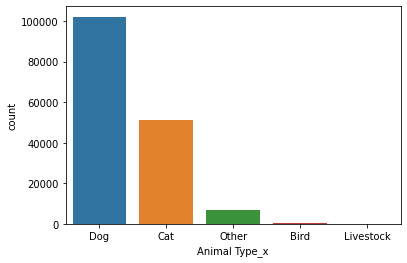

In [14]:
sns.countplot(x="Animal Type_x", data=how_long_duration)

אופני היציאה השונים 

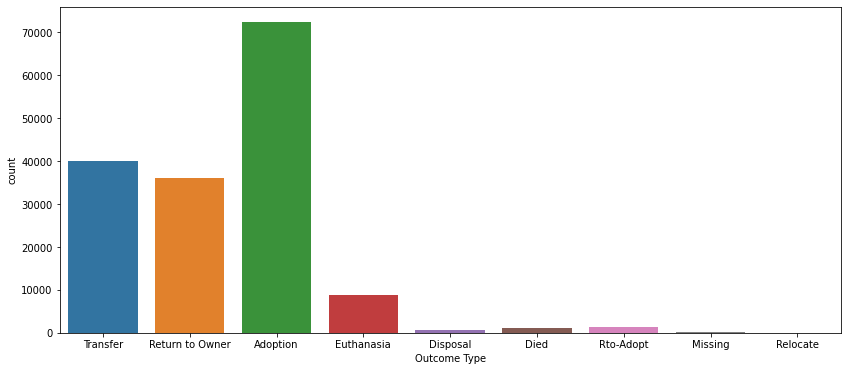

In [15]:
plt.figure(figsize=(14,6))
sns.countplot(x='Outcome Type', data=how_long_duration)

ווידוא לערכים שיצאו 

In [16]:
how_long_duration.sort_values(by='duration', ascending=True).head(3)

,Date of Birth,DateTime_x,DateTime_y,Animal Type_x,Intake Condition,Outcome Type,Intake Type,Sex upon Outcome,Breed_y,Color_y,duration,Age upon Intake,Age upon Outcome
6566,2008-01-20,2021-02-24 08:26:00,2014-01-29 16:09:00,Dog,Aged,Return to Owner,Public Assist,Spayed Female,Beagle/Jack Russell Terrier,White/Tan,-2583,4784,2201
19047,2012-11-24,2020-11-14 13:46:00,2013-11-27 15:55:00,Dog,Normal,Return to Owner,Stray,Neutered Male,Chihuahua Shorthair Mix,Tan/White,-2544,2912,368
140608,2005-02-13,2020-10-02 13:29:00,2014-01-15 11:17:00,Dog,Normal,Return to Owner,Public Assist,Neutered Male,Jack Russell Terrier/Maltese,White/Black,-2453,5710,3258


החלפת תאריכי כניסה ויציאה במקומות שהתבלבלו והכניסו תאריך יציאה לפני כניסה

In [17]:
for i in range(len(how_long_duration)): 
    if how_long_duration.iloc[i,10]<0:
        how_long_duration.iloc[i,11],how_long_duration.iloc[i,12]=how_long_duration.iloc[i,12],how_long_duration.iloc[i,11]

יצא ערכים שללים בתאריך זה עקב בילבול בין תאריך הכניסה והיציאה
נסדר אותם:

In [18]:
how_long_duration['duration']=how_long_duration['duration'].abs()
how_long_duration.sort_values(by='duration', ascending=True).head(3)

,Date of Birth,DateTime_x,DateTime_y,Animal Type_x,Intake Condition,Outcome Type,Intake Type,Sex upon Outcome,Breed_y,Color_y,duration,Age upon Intake,Age upon Outcome
135349,2014-08-07,2019-01-05 14:18:00,2019-01-05 17:31:00,Dog,Normal,Return to Owner,Stray,Intact Male,German Shepherd,Tan/Black,0,1612,1612
128064,2016-09-08,2016-10-08 11:28:00,2016-10-08 11:33:00,Other,Normal,Euthanasia,Wildlife,Unknown,Bat,Black/Brown,0,30,30
128065,2007-12-14,2013-12-14 12:34:00,2013-12-14 14:11:00,Dog,Normal,Return to Owner,Stray,Neutered Male,Great Dane,Black/White,0,2192,2192


נבדוק מה הסיפור עם הנתונים שיש להם 0 בזמן שהיה

In [19]:
zero_duration_adoption = how_long_duration.loc[how_long_duration.duration < 1] 
zero_duration_adoption['Outcome Type'].value_counts()

Transfer           10187
Return to Owner     8049
Euthanasia          5861
Adoption             818
Died                 362
Disposal             336
Rto-Adopt             17
Relocate               9
Missing                3
Name: Outcome Type, dtype: int64

נראה שיש יציאות מסיבות שונות ובכמות גדולה ולכן לא ניגע 

ממוצע השהיה לחיות

In [20]:
 how_long_duration.pivot_table('duration','Animal Type_x')

,duration
Animal Type_x,
Bird,8.061538
Cat,45.695588
Dog,112.197199
Livestock,79.368421
Other,5.458740


ממוצע השהיה לחיות עד זמן האימוץ לחיות שאומצו  

In [21]:
how_long_duration_adoption= how_long_duration.loc[how_long_duration['Outcome Type']== 'Adoption']
how_long_duration_adoption.pivot_table('duration','Animal Type_x')

,duration
Animal Type_x,
Bird,13.468293
Cat,67.829485
Dog,92.638925
Livestock,168.750000
Other,39.932264


שכלול הנתונים הנ"ל ובנוסף גם חישוב עבור כלבים וחתולים שלהם כמות גדולה

In [22]:
how_long_duration_dog = how_long_duration.loc[how_long_duration['Animal Type_x']== 'Dog']
how_long_duration_cat = how_long_duration.loc[how_long_duration['Animal Type_x']== 'Cat']
category_outcomes = [how_long_duration,how_long_duration_adoption,how_long_duration_dog,how_long_duration_cat]
category_outcomes_str = ['category_outcomes_str','how_long_duration_adoption','how_long_duration_dog','how_long_duration_cat']
list_static = []
for i in range(0,len(category_outcomes)):
    list_static.append({'mean' : category_outcomes[i].duration.mean(),'medain' : category_outcomes[i].duration.median(),'mode' : category_outcomes[i].duration.mode(),'std' :category_outcomes[i].duration.std()})    
statics_animel=pd.DataFrame(list_static, index=category_outcomes_str)
statics_animel

,mean,medain,mode,std
category_outcomes_str,86.222341,8.0,0 0 dtype: int64,233.548287
how_long_duration_adoption,83.733436,18.0,0 4 dtype: int64,207.836444
how_long_duration_dog,112.197199,9.0,0 0 dtype: int64,269.020313
how_long_duration_cat,45.695588,7.0,0 0 dtype: int64,150.223776


מעבר על קטגריות שונות סביב כלבים וחתולים כדי למצוא הפתעות

השארת כלבים וחתולים בלבד

In [23]:
how_long_duration.drop(how_long_duration.loc[how_long_duration['Animal Type_x'] == 'Other'].index,inplace = True)
how_long_duration.drop(how_long_duration.loc[how_long_duration['Animal Type_x'] == 'Bird'].index,inplace = True)
how_long_duration.drop(how_long_duration.loc[how_long_duration['Animal Type_x'] == 'Livestock'].index,inplace = True)

סיבת הכניסה וממוצע השהיה סביב זה:

In [24]:
how_long_duration['Intake Type'].value_counts()

Stray                 105096
Owner Surrender        35754
Public Assist          11745
Abandoned                282
Euthanasia Request       264
Name: Intake Type, dtype: int64

In [25]:
how_long_duration.pivot_table('duration', index=['Animal Type_x' ,'Intake Type'], aggfunc=np.mean)

duration
Animal Type_x Intake Type                   
Cat           Abandoned            37.296296
              Euthanasia Request   28.074627
              Owner Surrender      69.933164
              Public Assist        63.901546
              Stray                37.938992
Dog           Abandoned            42.787356
              Euthanasia Request   21.700508
              Owner Surrender     100.303494
              Public Assist       177.729840
              Stray               106.668985

מין הכלבים והחתולים והאם הם מעוקרים/מסורסים וההשפעה על משך השהייה:

In [26]:
how_long_duration['Sex upon Outcome'].value_counts()

Neutered Male    62230
Spayed Female    52654
Intact Male      17501
Intact Female    16401
Unknown           4355
Name: Sex upon Outcome, dtype: int64

In [27]:
how_long_duration.drop(how_long_duration.loc[how_long_duration['Sex upon Outcome'] == 'Unknown'].index,inplace = True)###שגיאה כל שהיא לטיפול מאיר ק
how_long_duration.pivot_table('duration', index=['Animal Type_x' ,'Sex upon Outcome'], aggfunc=np.mean)

duration
Animal Type_x Sex upon Outcome            
Cat           Intact Female      10.675737
              Intact Male         7.983215
              Neutered Male      65.599448
              Spayed Female      70.136461
Dog           Intact Female      53.319529
              Intact Male        74.194728
              Neutered Male     132.507794
              Spayed Female     112.590063

<h3> הופתענו לגלות שדווקא כאלו שאינם מסורסים זמן השהייה הממוצע שלהם היה קצר יותר<h3>

In [28]:
a = how_long_duration_dog['Outcome Type'].value_counts(normalize=True)
b = how_long_duration_cat['Outcome Type'].value_counts(normalize=True)
d= {'dog':a,'cat':b}
compare_cat_dog = pd.DataFrame(d)
compare_cat_dog['dog/cat']=compare_cat_dog.dog/compare_cat_dog.cat
compare_cat_dog['cat/dog']=compare_cat_dog.cat/compare_cat_dog.dog
compare_cat_dog = compare_cat_dog.drop(['Died','Disposal','Relocate','Missing','Rto-Adopt'], axis=0)
compare_cat_dog

,dog,cat,dog/cat,cat/dog
Adoption,0.464871,0.473455,0.981869,1.018466
Euthanasia,0.020403,0.038867,0.524934,1.905001
Return to Owner,0.325031,0.053853,6.035472,0.165687
Transfer,0.174729,0.414567,0.421474,2.372624


<h3>  כמה מסקנות על כלבים וחתולים:
    כלבים אובדים פי 6 מחתולים יתכן וזה עקב כך שכלבים נוטים להסתובב יותר מחוץ לבית מאשר חתולים.
חתולים ממותים פי שניים בהמתת חסד מכלבים וכן פי שניים חתולים מועברים למכלאות אחרות 
<h3>

<div>
<img src="dogpic.JPG" width="400"/>
</div>

<h2>2.כמות האימוץ ביחס למצב הבריאותי<h2>

In [29]:
condition=full_file.groupby('Intake Condition').count().sort_values(by='Intake Condition')
condition

,Animal ID,DateTime_x,Intake Type,Animal Type_x,Sex upon Intake,DateTime_y,Date of Birth,Outcome Type,Sex upon Outcome,Breed_y,Color_y
Intake Condition,,,,,,,,,,,
Aged,513,513,513,513,513,513,513,513,513,513,513
Behavior,25,25,25,25,25,25,25,25,25,25,25
Feral,112,112,112,112,112,112,112,112,112,112,112
Injured,7526,7526,7526,7526,7526,7526,7526,7526,7526,7526,7526
Medical,73,73,73,73,73,73,73,73,73,73,73
Normal,142733,142733,142733,142733,142733,142733,142733,142733,142733,142733,142733
Nursing,3624,3624,3624,3624,3624,3624,3624,3624,3624,3624,3624
Other,264,264,264,264,264,264,264,264,264,264,264
Pregnant,93,93,93,93,93,93,93,93,93,93,93


 מיון וסינון הדאטה לעבודה ממוקדת

Text(0.5, 1.0, 'non normal condition')

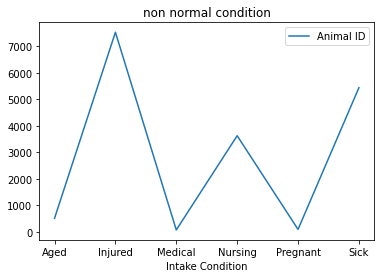

In [30]:
condition.iloc[[0,3,4,6,8,9],[0]].plot()
plt.title('non normal condition')

 עבודה על כל סוגי בריאות החיות הנכנסות למעט "נורמל"כיוון שלהפתעתנו כמות החיות הבריאות הייתה מאוד גדולה

Text(0.5, 1.0, 'includind normal condition')

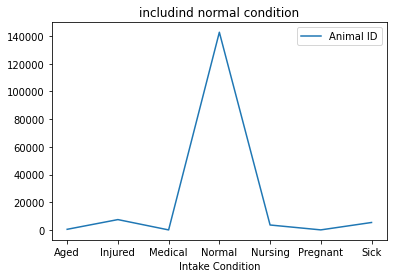

In [31]:
condition.iloc[[0,3,4,5,6,8,9],[0]].plot()
plt.title('includind normal condition')

למען הבהרת השוני ניתן לראות את 2 הגרפים הנ"ל ואת המשתמע מכך

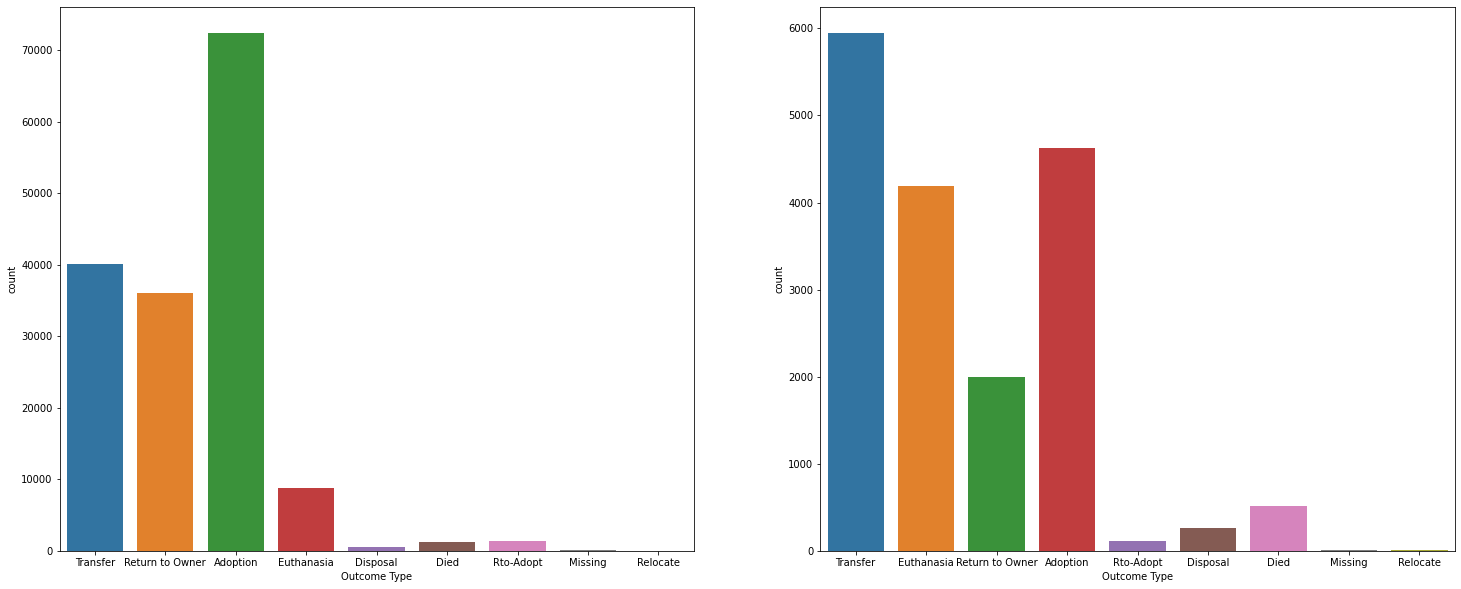

In [32]:
odd=full_file.drop(full_file.loc[full_file['Intake Condition'] =='Normal'].index)
fig, axes = plt.subplots(figsize=(25,10), ncols=2)
#axes[0].set(ylim=80000)
sns.countplot(x='Outcome Type',data =full_file,ax=axes[0])
sns.countplot(x='Outcome Type',data =odd,ax=axes[1])
plt.show()

במבט ראשוני אחוזי האימוץ נראים מעולה 46.1% אימוץ! אבל כשמנפים את החיות הבריאות מגלים שאחוזי האימוץ אצל חיות פצועות או במצב בריאותי מסובך הינו בערך 25% כלומר הבדל של 20% מהאימוץ הכללי. 

<div>
<img src="catinbox.JPG" width="400"/>
</div>

<h2>3.חיזויים

חיזוי שבודק מה יקרה לכלב או חתול(הם החיות העיקריות) שמגיע למוסד

חיזוי לכלבים

In [33]:
dog_data=how_long_duration[how_long_duration['Animal Type_x']=='Dog']
dog_model=dog_data[['Sex upon Outcome','Breed_y','Color_y', 'Intake Type','Intake Condition','Outcome Type','Age upon Intake','duration']].copy()
dog_model['Sex upon Outcome'] =dog_model['Sex upon Outcome'].astype('category').cat.codes
dog_model['Breed_y'] =dog_model['Breed_y'].astype('category').cat.codes
dog_model['Color_y'] =dog_model['Color_y'].astype('category').cat.codes
dog_model['Intake Type'] =dog_model['Intake Type'].astype('category').cat.codes
dog_model['Intake Condition'] =dog_model['Intake Condition'].astype('category').cat.codes


In [34]:
plt.figure(figsize=(10,7))
dog_data['Outcome Type'].value_counts(normalize=True)

Adoption           0.466964
Return to Owner    0.325727
Transfer           0.172585
Euthanasia         0.020053
Rto-Adopt          0.011384
Died               0.002460
Missing            0.000502
Disposal           0.000325
Name: Outcome Type, dtype: float64

<Figure size 720x504 with 0 Axes>

In [35]:
model = sk.tree.DecisionTreeClassifier(criterion="gini",random_state=1)
features = ['Intake Type','Intake Condition','Sex upon Outcome','Age upon Intake']
X = dog_model[features]
y = dog_model['Outcome Type']
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.3, random_state=1)
model.fit(X_train,y_train)
prediction = model.predict(X_test)
print("Depth:",model.get_depth())
sk.metrics.accuracy_score(prediction, y_test)

Depth: 41


0.6450639553952116

חיזוי לחתולים

In [36]:
cat_data=how_long_duration[how_long_duration['Animal Type_x']=='Cat']
cat_model=cat_data[['Sex upon Outcome','Breed_y','Color_y', 'Intake Type','Intake Condition','Outcome Type','Age upon Intake','duration']].copy()

cat_model['Sex upon Outcome'] =cat_model['Sex upon Outcome'].astype('category').cat.codes
cat_model['Breed_y'] =cat_model['Breed_y'].astype('category').cat.codes
cat_model['Color_y'] =cat_model['Color_y'].astype('category').cat.codes
cat_model['Intake Type'] =cat_model['Intake Type'].astype('category').cat.codes
cat_model['Intake Condition'] =cat_model['Intake Condition'].astype('category').cat.codes


In [37]:
cat_data['Outcome Type'].value_counts(normalize=True)

Adoption           0.512501
Transfer           0.377160
Return to Owner    0.057385
Euthanasia         0.035245
Died               0.012406
Rto-Adopt          0.003584
Disposal           0.000933
Missing            0.000742
Relocate           0.000042
Name: Outcome Type, dtype: float64

In [38]:
features = ['Intake Type','Intake Condition','Sex upon Outcome','Age upon Intake']###שגיאה בריצה לא ברור למה
X = cat_model[features]
y = cat_model['Outcome Type']
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.3, random_state=1)
model.fit(X_train,y_train)
prediction = model.predict(X_test)
print("Depth:",model.get_depth())
sk.metrics.accuracy_score(prediction, y_test)

Depth: 37


0.7392380009896091

<h3>
מסקנה: רואים שהחיזוי למה יקרה לחיה המגיעה למרכז הוא יחסית גבוהה אפשר להשתמש בזה במרכז החדש שנדע אם מגיע כלב או חתול מסוים נדע לתכנן מראש כגון אם החיזוי שימות אז נדע להרדים אותו במקום שנחזיק אותו כמה שנים

 עכשיו נבדוק חיזוי לכמה ימים נשארים במרכז העשה את זה בעזרת עץ רגרסיה כי זה רציף

חיזוי לכלבים

In [39]:
days_at_center = DecisionTreeRegressor(random_state=4)
features = ['Intake Type','Intake Condition','Sex upon Outcome','Age upon Intake','Color_y','Breed_y']
X = dog_model[features]
y = dog_model['duration']
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.3, random_state=1) 
days_at_center.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=4, splitter='best')

In [40]:
def eval(x_test,y_test,model):
    pred =days_at_center.predict(x_test) 
    print("MSE: {:.3f}".format(mean_squared_error(pred,y_test,squared=False)))
    print("Depth:",days_at_center.get_depth())
    eval(X_test,y_test,days_at_center)

In [41]:
model3=sk.tree.DecisionTreeRegressor()
model3.fit(X_train,y_train)
prediction3=model3.predict( X_test)
print("Depth:",model3.get_depth())
"MSE: {:.3f}".format(mean_squared_error(prediction3,y_test,squared=False))

Depth: 43


'MSE: 304.514'

חיזוי לחתולים

In [42]:
days_at_center = DecisionTreeRegressor(random_state=4)
features = ['Intake Type','Intake Condition','Sex upon Outcome','Age upon Intake','Color_y','Breed_y']
X = cat_model[features]
y = cat_model['duration']
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.3, random_state=1) 
days_at_center.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=4, splitter='best')

In [43]:
model4=sk.tree.DecisionTreeRegressor()
model4.fit(X_train,y_train)
prediction4=model4.predict( X_test)
print("Depth:",model4.get_depth())
"MSE: {:.3f}".format(mean_squared_error(prediction4,y_test,squared=False))

Depth: 39


'MSE: 199.094'

 <h3>הסטייה גדולה יש חיות שנשארים יום ויש כאלה 10 שנים אי אפשר לחזות כמה זמן כל חיה תישאר 

<div>
<img src="cutecats.JPG" width="400"/>
</div>

<h2>4. השוואות בין זמני כניסה ויציאה מהמוסד ותובנות:

הכנסת הנתונים של הזמני כניסה ויציאה מהמאגר לשתי דאטות שונות ופירוקם לגורמים(שנים,חודשים,ימים,ימי השבוע,שעות)

In [44]:
Login_date=full_file[['DateTime_x']].copy()

In [45]:
departure_time=full_file[['DateTime_y']].copy()

In [46]:
departure_time['year'] = pd.DatetimeIndex(departure_time.DateTime_y).year
departure_time['month'] = pd.DatetimeIndex(departure_time.DateTime_y).month
departure_time['day'] = pd.DatetimeIndex(departure_time.DateTime_y).day
departure_time['weekday'] = pd.DatetimeIndex(departure_time.DateTime_y).weekday
departure_time['leaving time'] = pd.DatetimeIndex(departure_time.DateTime_y).hour

In [47]:
Login_date['year'] = pd.DatetimeIndex(Login_date.DateTime_x).year
Login_date['month'] = pd.DatetimeIndex(Login_date.DateTime_x).month
Login_date['day'] = pd.DatetimeIndex(Login_date.DateTime_x).day
Login_date['weekday'] = pd.DatetimeIndex(Login_date.DateTime_x).weekday
Login_date['entrance time'] = pd.DatetimeIndex(Login_date.DateTime_x).hour

:הצגת ההתפלגות היציאות מהמוסד על פי חודשים

Text(0.5, 1.0, 'monthly distrbution')

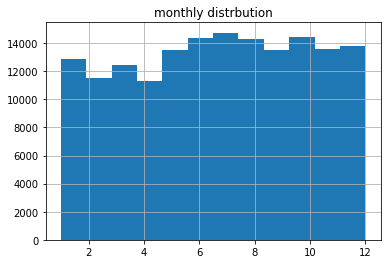

In [48]:
departure_time.hist('month', bins=12)
plt.title('monthly distrbution')

   .מסקנה: ניתן לראות שבחודשי החורף(1-4)יש ירידה בכמויות היציאות מהמוסד 

הצגת התפלגות הכניסות על ידי גרף: ניתן לראות שבין השעה 00 לשעה 06 בבוקר יש ירידה חדה בכמות הנכנסים

In [49]:
Login_date.value_counts('entrance time')

entrance time
11    25364
12    21456
13    19385
14    16874
15    16378
16    15598
17    10789
18    10118
10     7784
9      3827
8      3019
7      2448
19     2208
22     1000
21      985
23      921
20      808
0       519
6       323
1       262
2       135
3       100
4        56
5        41
dtype: int64

סינון השעות שבהם המרכז הפעילות במוסד היתה זניחה(00-06) 

In [50]:
Login_date=Login_date[Login_date['entrance time'] > 6]
departure_time=departure_time[departure_time['leaving time'] > 6]

In [51]:
a=Login_date[['entrance time']]
b=departure_time[['leaving time']]
data_of_the_hours=pd.concat([a, b], axis=1)

הצגת זמני הכניסה למוסד וזמני היציאה מהמוסד על פי שעות הפעילות המשמעתיות

Text(0.5, 1.0, 'Comparison between entering and exiting from the institution')

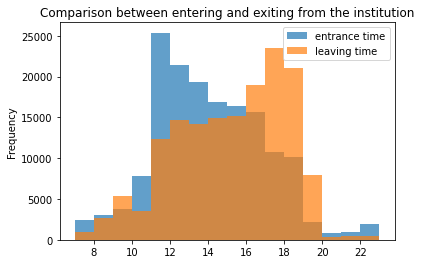

In [52]:
data_of_the_hours.plot.hist(bins=16, alpha=0.7)
plt.title('Comparison between entering and exiting from the institution')

<h3>מסקנה: ניתן לראות שיש עומס גדול יותר בסוף שעות הפעילות ביציאות מהמוסד, ועומס גדול יותר בתחילת שעות הפעילות של הכניסות למוסד.
    זה מעניין אותנו בחלוקת סוגי אנשי מקצוע לשעות שונות בשעות פעילות

<div>
<img src="dogjumping.JPG" width="400"/>
</div>